In [1]:
import pandas as pd
import pandas_datareader as web
from matplotlib import pyplot as plt
import numpy as np

Asset_name = 'SPY'
Benchmark_name = '^GSPC'

asset=web.DataReader(name=Asset_name,data_source='yahoo',start='1/01/2000',end='17/06/19')
benchmark=web.DataReader(name=Benchmark_name,data_source='yahoo',start='1/01/2000',end='17/06/19')

In [2]:
asset.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,148.25000,143.875000,148.25000,145.4375,8164300.0,100.934494
2000-01-04,144.06250,139.640625,143.53125,139.7500,8089800.0,96.987312
2000-01-05,141.53125,137.250000,139.93750,140.0000,12177900.0,97.160843
2000-01-06,141.50000,137.750000,139.62500,137.7500,6227200.0,95.599319
2000-01-07,145.75000,140.062500,140.31250,145.7500,8066500.0,101.151367


In [3]:
benchmark.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,1478.000000,1438.359985,1469.250000,1455.219971,931800000,1455.219971
2000-01-04,1455.219971,1397.430054,1455.219971,1399.420044,1009000000,1399.420044
2000-01-05,1413.270020,1377.680054,1399.420044,1402.109985,1085500000,1402.109985
2000-01-06,1411.900024,1392.099976,1402.109985,1403.449951,1092300000,1403.449951
2000-01-07,1441.469971,1400.729980,1403.449951,1441.469971,1225200000,1441.469971


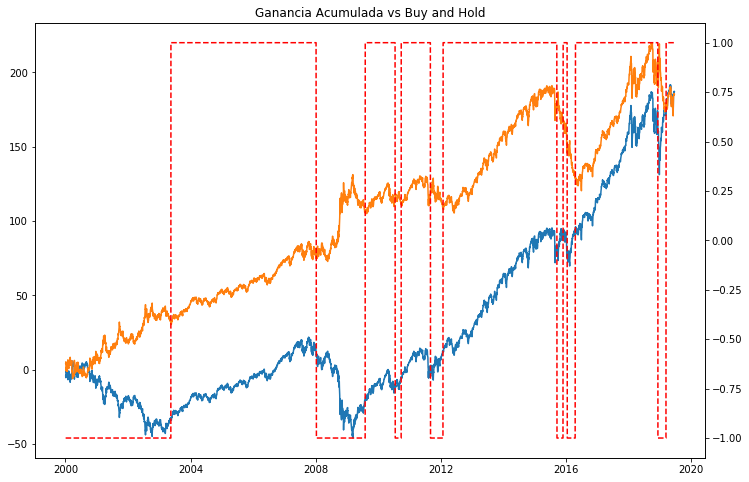

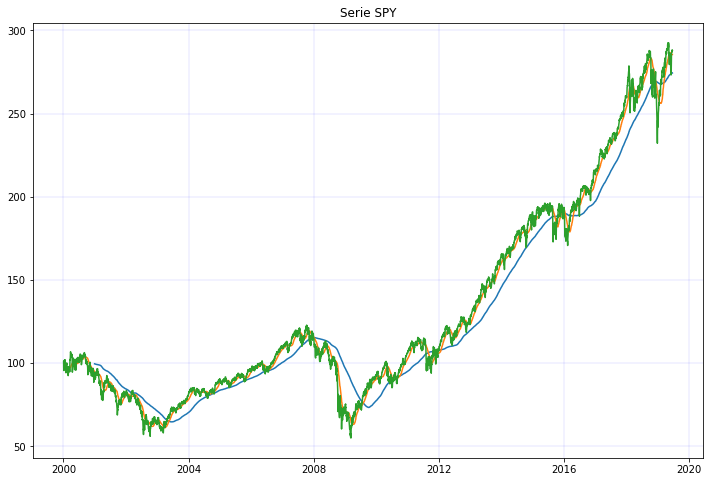

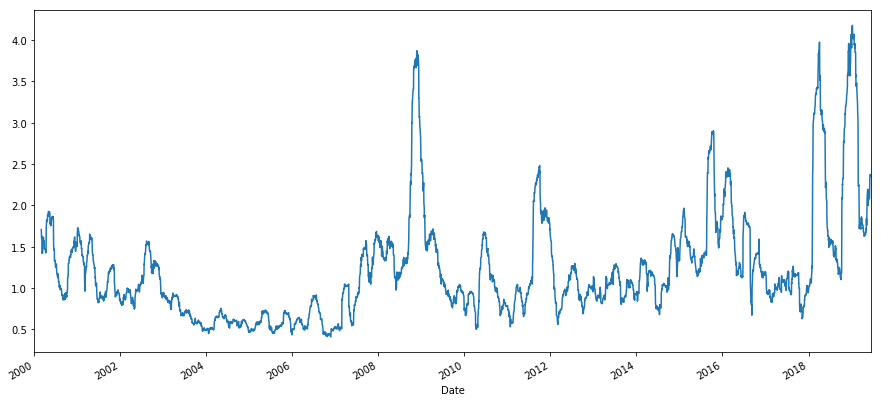

In [0]:
short_mean=42
long_mean = 252
difference = 0

asset[str(long_mean)+'d']=asset['Adj Close'].rolling(long_mean).mean()
asset[str(short_mean)+'d']=asset['Adj Close'].rolling(short_mean).mean()
asset['Signals'] = (asset[str(long_mean)+'d'] - asset[str(short_mean)+'d'] < difference)*2 - 1
asset['Market'] = asset['Adj Close'].diff()
asset['Strategy'] = asset['Market'] * asset['Signals'].shift(1)
benchmark['Returns']= np.log(benchmark['Adj Close']/benchmark['Adj Close'].shift(1))
asset['Returns']= np.log(asset['Adj Close']/asset['Adj Close'].shift(1))

fig, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(asset[['Market','Strategy']].cumsum())

ax2 = ax1.twinx()
ax2.plot(asset['Signals'],'r--',label='Señales', markersize=1)
plt.title('Ganancia Acumulada vs Buy and Hold')
plt.show()

plt.figure(figsize=(12,8))
plt.grid(color='b', linestyle='-', linewidth=.1);
plt.plot(asset[[str(long_mean)+'d',str(short_mean)+'d','Adj Close']])
plt.title('Serie SPY')
plt.show()

asset['Adj Close'].diff().rolling(short_mean).std().plot(figsize=(15,7))
plt.show()

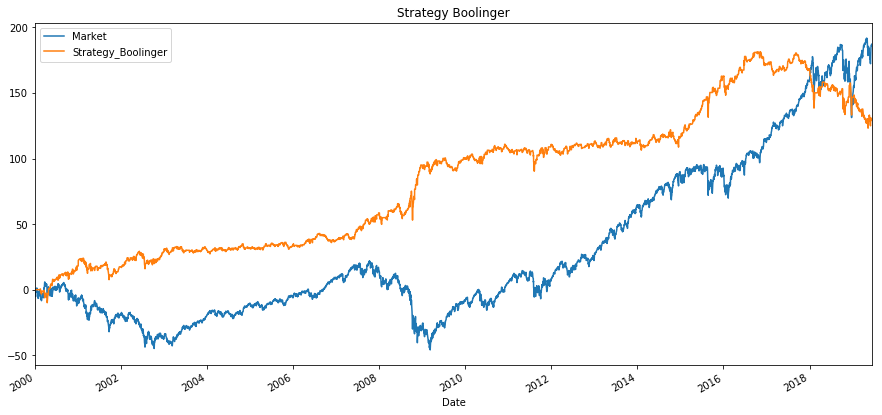

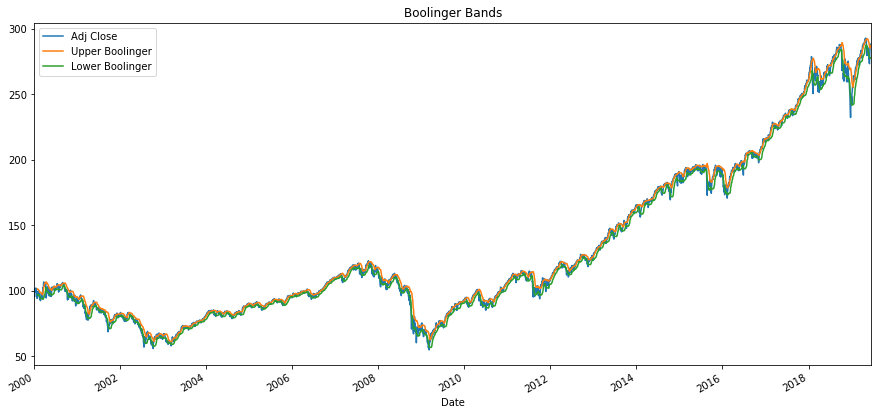

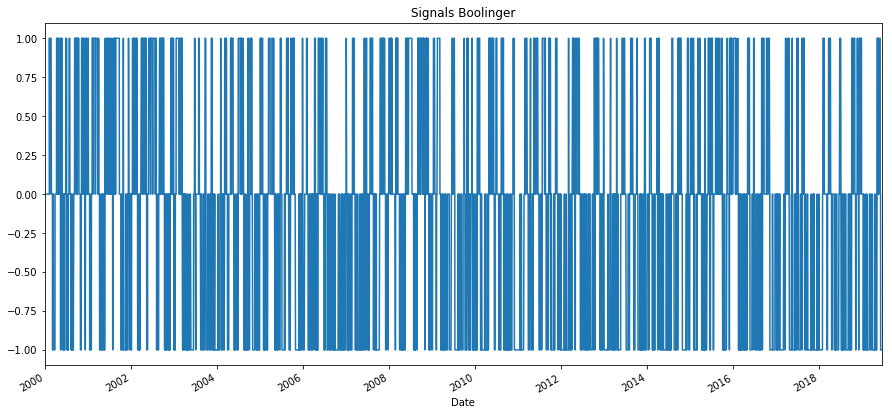

In [0]:
# Boolinger Bands

roll=asset['Adj Close'].rolling(20)

asset['Upper Boolinger'] =roll.mean()+1*roll.std()
asset['Lower Boolinger'] =roll.mean()-1*roll.std()
asset['Signals_Boolinger'] = np.where(asset['Adj Close'] > asset['Upper Boolinger'], -1, 0)
asset['Signals_Boolinger'] = np.where(asset['Adj Close'] < asset['Lower Boolinger'], 1, asset['Signals_Boolinger'])
asset['Strategy_Boolinger'] = asset['Market'] * asset['Signals_Boolinger'].shift(1)
asset[['Market','Strategy_Boolinger']].cumsum().plot(title='Strategy Boolinger',figsize=(15,7))
plt.show()
asset[['Adj Close','Upper Boolinger','Lower Boolinger']].plot(title='Boolinger Bands',figsize=(15,7))
plt.show()
asset['Signals_Boolinger'].plot(title='Signals Boolinger',figsize=(15,7))
plt.show()

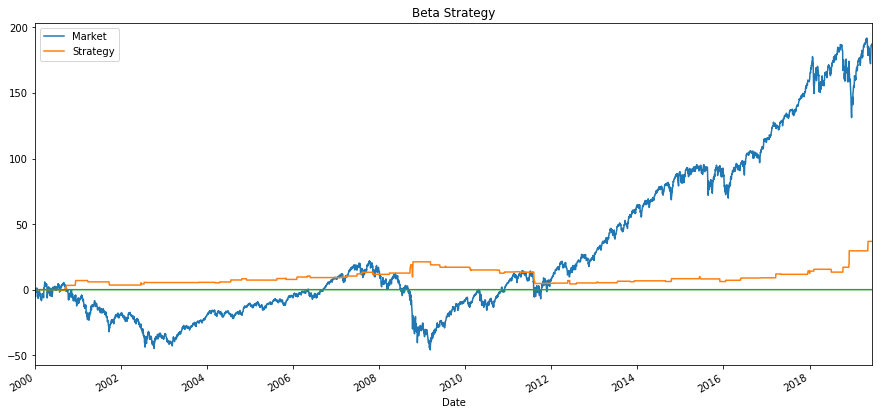

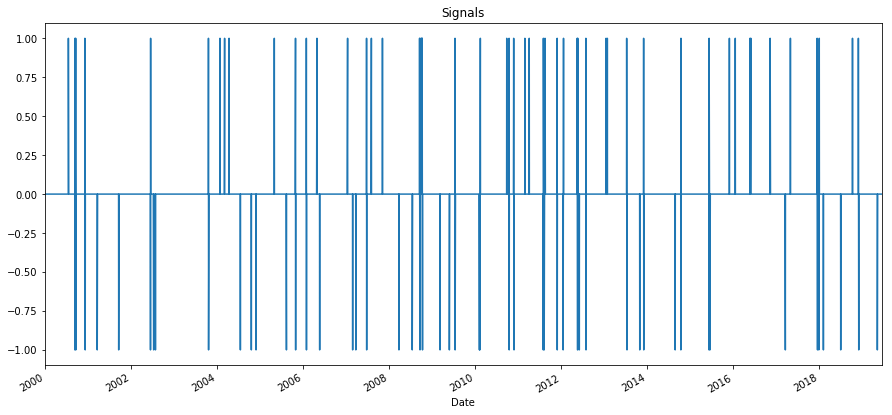

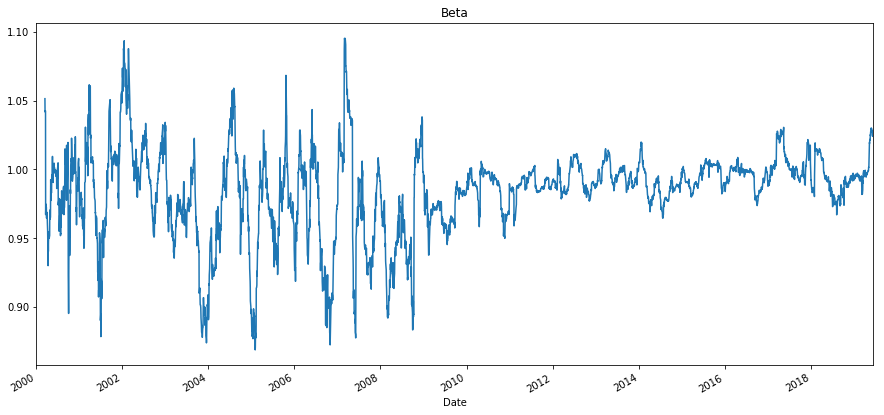

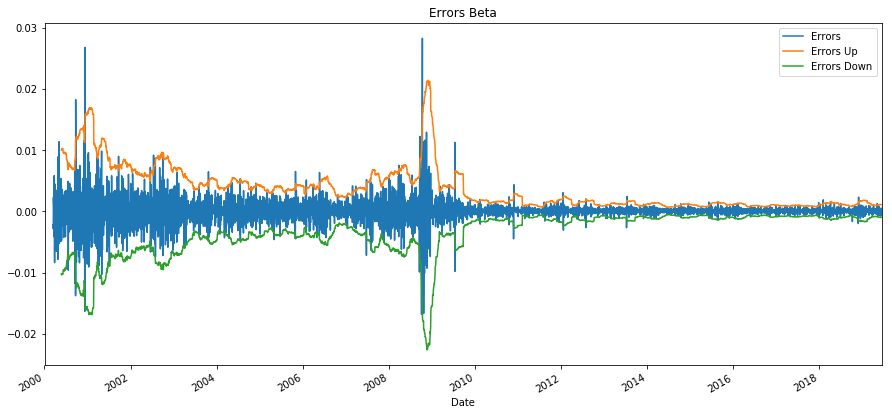

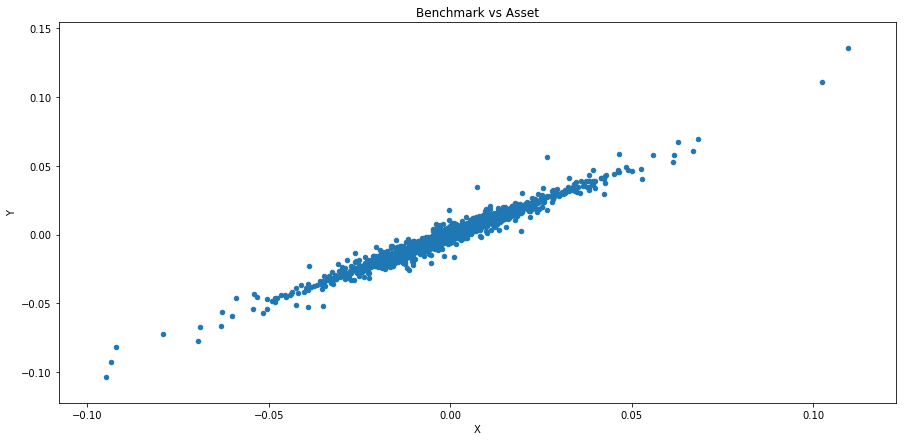

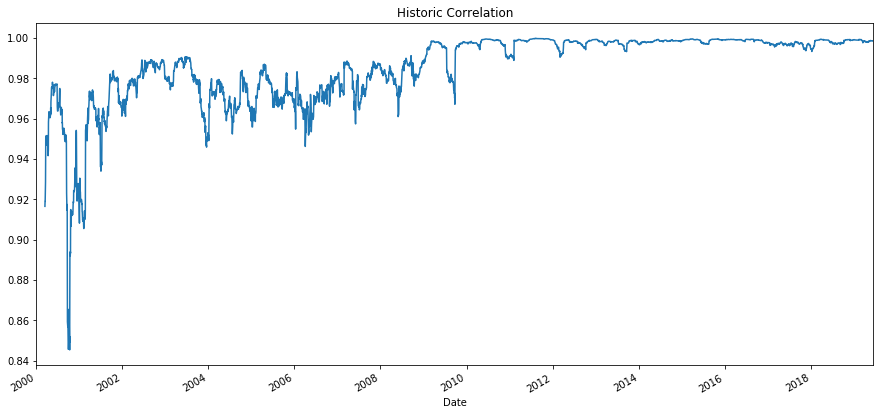

In [0]:
window = 50
sd=2.5
df=pd.DataFrame()
df['X']=benchmark['Returns']
df['Y']=asset['Returns']

stats=df.rolling(window).cov(pairwise =True).unstack()

df['Beta']=stats['X']['Y']/stats['X']['X']

df['Correlation']=stats['X']['Y']/np.sqrt(stats['X']['X']*stats['Y']['Y'])

df['Errors']=df['Y'] - df['X']*df['Beta']

roll_errors=df['Errors'].rolling(window)

df['Errors Up'] = roll_errors.mean() + sd*roll_errors.std()

df['Errors Down'] = roll_errors.mean() - sd*roll_errors.std()

df['Signals'] = np.where(df['Errors'] > df['Errors Up'], -1, 0)
df['Signals'] = np.where(df['Errors'] < df['Errors Down'], 1, df['Signals'])
df['Market'] = asset['Adj Close'].diff()

df['Strategy'] = df['Market'] * df['Signals'].shift(1)


df[['Market','Strategy']].cumsum().plot(title='Beta Strategy',figsize=(15,7))
plt.plot(df['Market']*0)
plt.show()
df['Signals'].plot(title='Signals',figsize=(15,7))
plt.show()
df['Beta'].plot(title='Beta',figsize=(15,7))
plt.show()
df[['Errors','Errors Up','Errors Down']].plot(title='Errors Beta',figsize=(15,7))
plt.show()
df.plot(x='X',y='Y',kind='scatter',title='Benchmark vs Asset',figsize=(15,7))
plt.show()
df['Correlation'].plot(title='Historic Correlation',figsize=(15,7))

In [0]:
print('Strategy SR: ',((df['Strategy'].sum()+1)**(1/18)-1)/(df['Strategy'].cumsum().std())/np.sqrt(18))
print('Market SR: ',((df['Market'].sum()+1)**(1/18)-1)/df['Market'].cumsum().std()/np.sqrt(18))

Strategy SR:  0.009116682722129333
Market SR:  0.0013072860918549195
